In [1]:
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
from dateutil import parser
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline

In [67]:
def process_csv(csv_path, test=False):
    if not test:
        columns = ['Timestamp', 'Hour', 'Ad', 'Browser', 'Platform', 'Region', 'Clicked']
    else:
        columns = ['Timestamp', 'Hour', 'Browser', 'Platform', 'Region']
    
    df = pd.read_csv(csv_path, names=columns)

    ## Engineer date features from Timestamp ##
    #df['Hour'] = df['Timestamp'].apply(lambda x: round((float(x.split(':')[0][-2:]) + float(x.split(':')[1])/60), 1))
    df['Day_of_week'] = df['Timestamp'].apply(lambda x: parser.parse(x).strftime("%A"))
    df['Day'] = df['Timestamp'].apply(lambda x: int(x.split('-')[2][:2]))
    df['Year'] = df['Timestamp'].apply(lambda x: int(x.split('-')[0]))
    df['Month'] = df['Timestamp'].apply(lambda x: int(x.split('-')[1]))
    df.drop(['Timestamp'], axis=1, inplace=True)

    ## Numerize categorical string features.
    for col in  df.columns:
        if df[col].dtype == "object":
            catigories = list(df[col].unique())
            df[col] = df[col].apply(lambda cat: catigories.index(cat))


    return df

In [111]:
def modelfit(alg, dtrain, features, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=25):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[features].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    #Declare X, y
    X = dtrain[features]
    y = dtrain[target]
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric='auc')
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy (Train): {}".format(metrics.accuracy_score(y, alg.predict(X)))
    print "Accuracy (CV): {}".format(cross_val_score(alg, X, y, cv=5).mean())
    print "AUC Score (Train): {}".format(cvresult['train-auc-mean'].max())
    print "AUC Score (Test): {}".format(cvresult['test-auc-mean'].max())                                                     
    print "Best cv iteration n_estimators:", cvresult.shape[0]
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [68]:
# Parameters
train_csv = '../training.csv'
train = process_csv(train_csv, test=False)
train.head(5)

,Hour,Ad,Browser,Platform,Region,Clicked,Day_of_week,Day,Year,Month
0,5,0,0,0,0,1,0,13,2014,4
1,6,0,1,0,1,0,1,14,2014,4
2,4,1,2,1,2,0,1,7,2014,4
3,7,1,3,1,3,0,2,25,2014,4
4,16,2,4,2,2,0,3,19,2014,4


In [100]:
# Declare Target
target = 'Clicked'
exclude = ['N/a']

# Choose all predictors except target & exclude
features = [x for x in train.columns if x not in [target] + exclude]
features = ['Hour', 'Region', 'Ad']
#features = ['Hour', 'Region', 'Ad', 'Day']

print features

['Hour', 'Region', 'Ad']



Model Report
Accuracy (Train): 0.725
Accuracy (CV): 0.705200419925
AUC Score (Train): 0.8021292
AUC Score (Test): 0.7882276
Best cv iteration n_estimators: 23


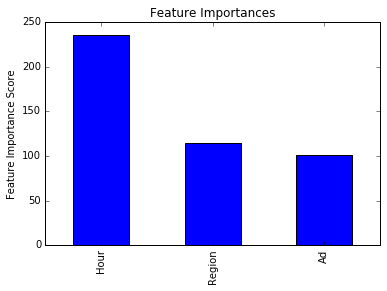

In [122]:
xgb1 = XGBClassifier(
    learning_rate =0.5,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=6,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic')
    #scale_pos_weight=1)
    #seed=27)
modelfit(xgb1, train, features, target)

Model Report
Accuracy (Train): 0.7321
Accuracy (CV): 0.7041003699
AUC Score (Train): 0.8131328
AUC Score (Test): 0.7842468
Best cv iteration n_estimators: 75

Model Report
Accuracy (Train): 0.7238
Accuracy (CV): 0.703201320075
AUC Score (Train): 0.8033678
AUC Score (Test): 0.7888138
Best cv iteration n_estimators: 213

Model Report
Accuracy (Train): 0.7368
Accuracy (CV): 0.70559907005
AUC Score (Train): 0.8183934
AUC Score (Test): 0.7848754
Best cv iteration n_estimators: 110

In [123]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.5, n_estimators=23, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic'), 
 param_grid = param_test1, scoring='roc_auc', iid=False, cv=5)
gsearch1.fit(train[features],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.78271, std: 0.00742, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.78268, std: 0.00743, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.78205, std: 0.00829, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.78500, std: 0.00698, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.78516, std: 0.00640, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.78556, std: 0.00622, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.78256, std: 0.00667, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.78336, std: 0.00672, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.78377, std: 0.00682, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.78193, std: 0.00680, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.78228, std: 0.00695, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.78300, std: 0.00710, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

In [128]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.5, n_estimators=23, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic'), 
 param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(train[features],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.78656, std: 0.00745, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.78674, std: 0.00752, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.78601, std: 0.00706, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.78601, std: 0.00629, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.78556, std: 0.00622, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.78533, std: 0.00651, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.78404, std: 0.00673, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.78381, std: 0.00670, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.78346, std: 0.00660, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 4, 'min_child_weight': 5},
 0.78673796784826455)

In [126]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.5, n_estimators=23, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic'), 
 param_grid = param_test3, scoring='roc_auc', iid=False, cv=5)
gsearch3.fit(train[features],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.78046, std: 0.00871, params: {'gamma': 0.0},
  mean: 0.78048, std: 0.00879, params: {'gamma': 0.1},
  mean: 0.78051, std: 0.00882, params: {'gamma': 0.2},
  mean: 0.78048, std: 0.00861, params: {'gamma': 0.3},
  mean: 0.78059, std: 0.00852, params: {'gamma': 0.4},
  mean: 0.78063, std: 0.00842, params: {'gamma': 0.5},
  mean: 0.78047, std: 0.00856, params: {'gamma': 0.6},
  mean: 0.78048, std: 0.00855, params: {'gamma': 0.7},
  mean: 0.78027, std: 0.00867, params: {'gamma': 0.8},
  mean: 0.78043, std: 0.00852, params: {'gamma': 0.9}],
 {'gamma': 0.5},
 0.78063496071291116)


Model Report
Accuracy (Train): 0.7244
Accuracy (CV): 0.706900720375
AUC Score (Train): 0.8022822
AUC Score (Test): 0.7885056
Best cv iteration n_estimators: 26


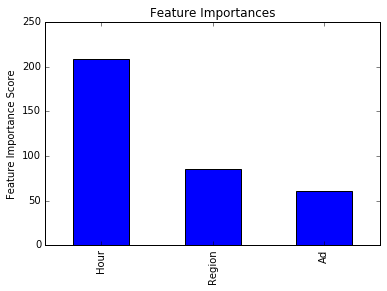

In [130]:
xgb2 = XGBClassifier(
 learning_rate =0.5,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0.5,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic')
 #scale_pos_weight=1)
 #seed=27)
modelfit(xgb2, train, features, target)

In [138]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.5, n_estimators=26, max_depth=5,
 min_child_weight=5, gamma=0.5, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic'), 
 param_grid = param_test4, scoring='roc_auc', iid=False, cv=5)
gsearch4.fit(train[features],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.62263, std: 0.01423, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.62338, std: 0.01510, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.62318, std: 0.01476, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.62386, std: 0.01514, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.78482, std: 0.00723, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.78503, std: 0.00678, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.78536, std: 0.00759, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.78537, std: 0.00717, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.78482, std: 0.00723, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.78503, std: 0.00678, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.78536, std: 0.00759, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.78537, std: 0.00717, params: {'subsample': 0.9, 'colsample_bytree'

In [140]:
param_test5 = {
 'subsample': np.linspace(0.6, 0.8, 10),
 'colsample_bytree': np.linspace(0.8, 1.0, 10)
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.5, n_estimators=26, max_depth=5,
 min_child_weight=5, gamma=0.5, subsample=0.8, colsample_bytree=0.7,
 objective= 'binary:logistic'), 
 param_grid = param_test5, scoring='roc_auc', iid=False, cv=5)
gsearch5.fit(train[features],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.78482, std: 0.00723, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.80000000000000004},
  mean: 0.78507, std: 0.00750, params: {'subsample': 0.62222222222222223, 'colsample_bytree': 0.80000000000000004},
  mean: 0.78457, std: 0.00785, params: {'subsample': 0.64444444444444449, 'colsample_bytree': 0.80000000000000004},
  mean: 0.78433, std: 0.00798, params: {'subsample': 0.66666666666666663, 'colsample_bytree': 0.80000000000000004},
  mean: 0.78475, std: 0.00784, params: {'subsample': 0.68888888888888888, 'colsample_bytree': 0.80000000000000004},
  mean: 0.78459, std: 0.00765, params: {'subsample': 0.71111111111111114, 'colsample_bytree': 0.80000000000000004},
  mean: 0.78399, std: 0.00714, params: {'subsample': 0.73333333333333339, 'colsample_bytree': 0.80000000000000004},
  mean: 0.78436, std: 0.00746, params: {'subsample': 0.75555555555555554, 'colsample_bytree': 0.80000000000000004},
  mean: 0.78494, std: 0.00846, params: {'subsample': 0.77777777777777779

In [141]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.5, n_estimators=26, max_depth=5,
    min_child_weight=5, gamma=0.5, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic'), 
    param_grid = param_test6, scoring='roc_auc', iid=False, cv=5)
gsearch6.fit(train[features],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.78536, std: 0.00759, params: {'reg_alpha': 1e-05},
  mean: 0.78532, std: 0.00695, params: {'reg_alpha': 0.01},
  mean: 0.78592, std: 0.00772, params: {'reg_alpha': 0.1},
  mean: 0.78647, std: 0.00708, params: {'reg_alpha': 1},
  mean: 0.76621, std: 0.00845, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.78647101994853674)

In [145]:
param_test7 = {
 'reg_alpha': np.linspace(1, 2, 10)
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.5, n_estimators=26, max_depth=5,
    min_child_weight=5, gamma=0.5, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic'), 
    param_grid = param_test7, scoring='roc_auc', iid=False, cv=5)
gsearch7.fit(train[features],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.78647, std: 0.00708, params: {'reg_alpha': 1.0},
  mean: 0.78604, std: 0.00726, params: {'reg_alpha': 1.1111111111111112},
  mean: 0.78546, std: 0.00734, params: {'reg_alpha': 1.2222222222222223},
  mean: 0.78595, std: 0.00784, params: {'reg_alpha': 1.3333333333333333},
  mean: 0.78612, std: 0.00731, params: {'reg_alpha': 1.4444444444444444},
  mean: 0.78682, std: 0.00792, params: {'reg_alpha': 1.5555555555555556},
  mean: 0.78627, std: 0.00745, params: {'reg_alpha': 1.6666666666666665},
  mean: 0.78634, std: 0.00700, params: {'reg_alpha': 1.7777777777777777},
  mean: 0.78668, std: 0.00727, params: {'reg_alpha': 1.8888888888888888},
  mean: 0.78656, std: 0.00753, params: {'reg_alpha': 2.0}],
 {'reg_alpha': 1.5555555555555556},
 0.78681513823022309)


Model Report
Accuracy (Train): 0.7221
Accuracy (CV): 0.7080006709
AUC Score (Train): 0.8015228
AUC Score (Test): 0.7891036
Best cv iteration n_estimators: 34


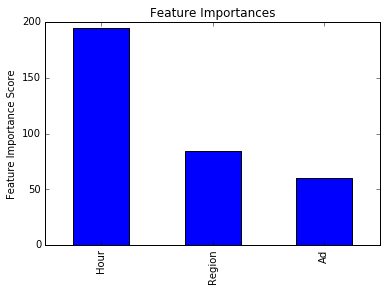

In [146]:
xgb3 = XGBClassifier(
    learning_rate =0.5,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=5,
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha = 1.5,
    objective = 'binary:logistic')
    #scale_pos_weight=1)
    #seed=27)
modelfit(xgb3, train, features, target)

In [ ]:
Model Report
Accuracy (Train): 0.734
Accuracy (Test): 0.7217
AUC Score (Train): 0.814168
AUC Score (Test): 0.790539

In [147]:
param_test8 = {
 'learning_rate': np.linspace(0.01, 1, 25)
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.5, n_estimators=34, max_depth=5,
    min_child_weight=5, gamma=0.5, subsample=0.8, colsample_bytree=0.8, reg_alpha = 1.5,
    objective= 'binary:logistic'), 
    param_grid = param_test8, scoring='roc_auc', iid=False, cv=5)
gsearch8.fit(train[features],train[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.77615, std: 0.01011, params: {'learning_rate': 0.01},
  mean: 0.78246, std: 0.00915, params: {'learning_rate': 0.051250000000000004},
  mean: 0.78566, std: 0.00816, params: {'learning_rate': 0.092499999999999999},
  mean: 0.78704, std: 0.00797, params: {'learning_rate': 0.13375000000000001},
  mean: 0.78745, std: 0.00724, params: {'learning_rate': 0.17500000000000002},
  mean: 0.78797, std: 0.00708, params: {'learning_rate': 0.21625000000000003},
  mean: 0.78788, std: 0.00641, params: {'learning_rate': 0.25750000000000001},
  mean: 0.78726, std: 0.00674, params: {'learning_rate': 0.29875000000000002},
  mean: 0.78701, std: 0.00666, params: {'learning_rate': 0.34000000000000002},
  mean: 0.78694, std: 0.00668, params: {'learning_rate': 0.38125000000000003},
  mean: 0.78664, std: 0.00646, params: {'learning_rate': 0.42250000000000004},
  mean: 0.78652, std: 0.00690, params: {'learning_rate': 0.46375000000000005},
  mean: 0.78583, std: 0.00737, params: {'learning_rate': 0.505},



Model Report
Accuracy (Train): 0.7239
Accuracy (CV): 0.707700720375
AUC Score (Train): 0.8011852
AUC Score (Test): 0.7899902
Best cv iteration n_estimators: 57


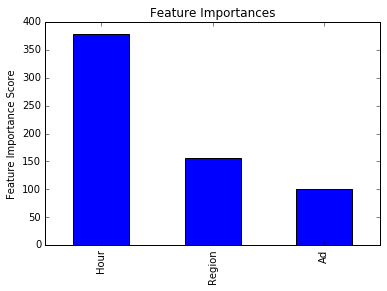

In [148]:
xgb4 = XGBClassifier(
    learning_rate =0.2,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=5,
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=0.78,
    reg_alpha = 1.5,
    objective = 'binary:logistic')
    #scale_pos_weight=1)
    #seed=27)
modelfit(xgb4, train, features, target)

In [ ]:
Model Report
Accuracy (Train): 0.7207
Accuracy (CV): 0.7142012709
AUC Score (Train): 0.7967038
AUC Score (Test): 0.790672
Best cv iteration n_estimators: 54